# Chemical features Prediction

### Raw Data Exploration

* Show head (6 rows) of raw train data
* Color map of chemical over longitude and latitude

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

chem_train = pd.read_csv("data/train_clean.csv")
chem_query = pd.read_csv("data/test_clean.csv")
display(chem_train.head())
display(chem_query.head())

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-179,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-178,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-177,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-176,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
features = list(chem_train.columns)
features.remove("longitude")
features.remove("latitude")
features.remove("lithology")
print(features)
def draw_global(lon, lat, y, title, vmin=None, vmax=None):
    if vmin is None and vmax is None:
        sc = plt.scatter(lon, lat, s=0.5, c=y)
    else:
        sc = plt.scatter(lon, lat, s=0.5, c=y, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
    
# start chemical feature exploration
lon = chem_train["longitude"].values
lat = chem_train["latitude"].values

['bathymetry', 'nitrate', 'oxygen', 'phosphate', 'productivity', 'salinity', 'silicate', 'temperature']


### Apply regression model to model chemical everywhere

Only use longitude and latitude to predict chemical (e.g. nitrage)

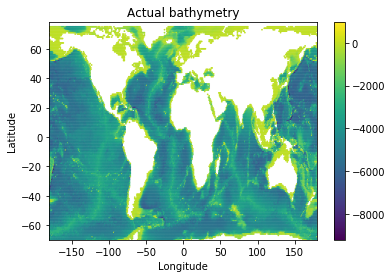

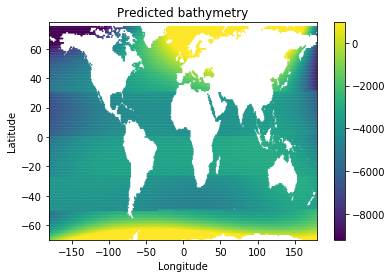

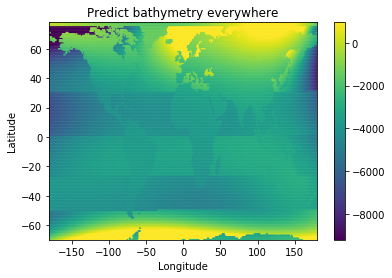

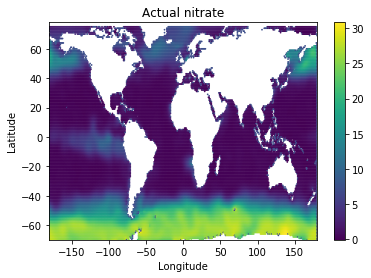

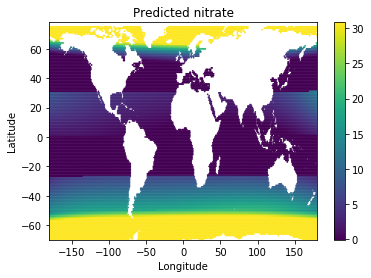

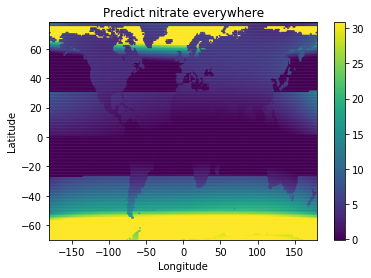

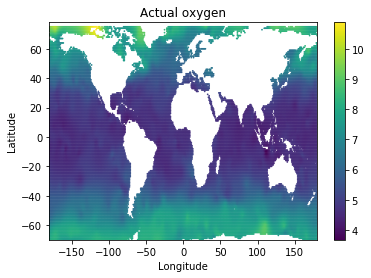

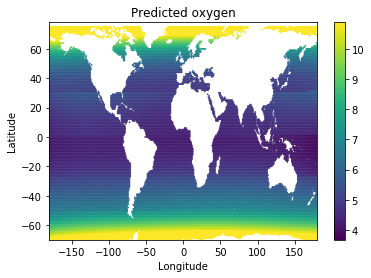

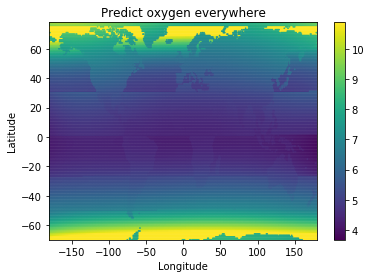

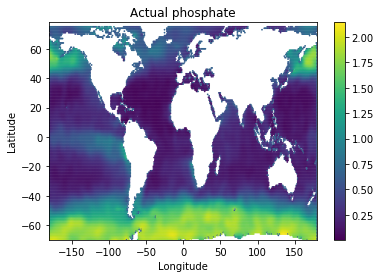

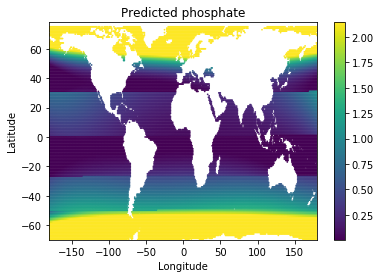

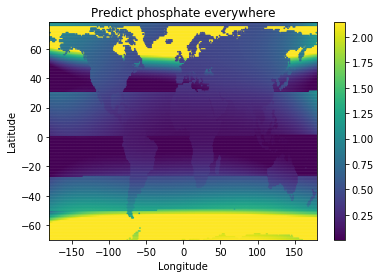

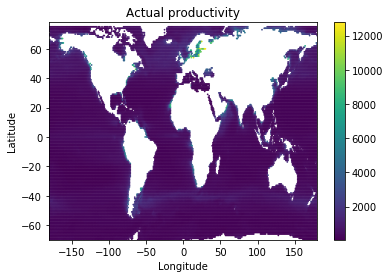

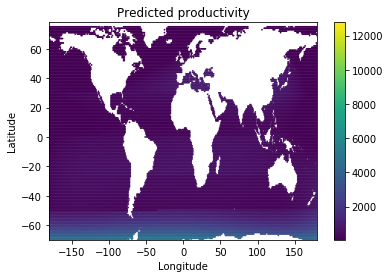

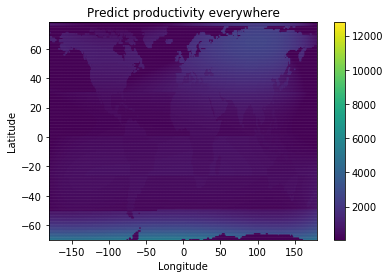

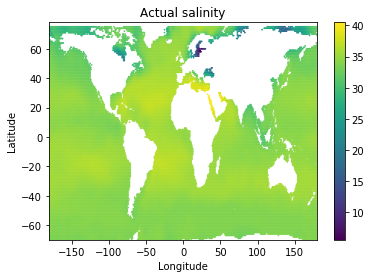

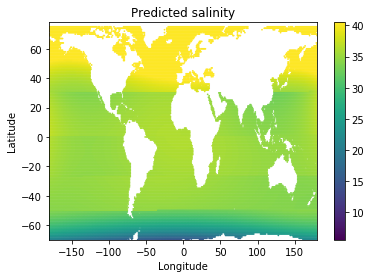

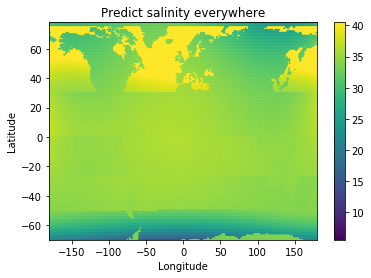

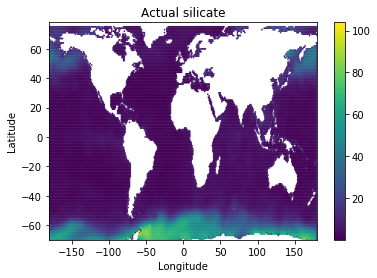

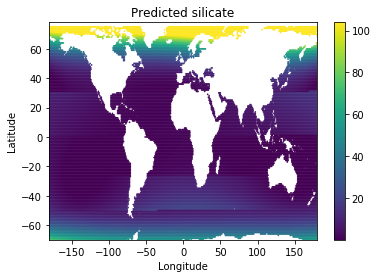

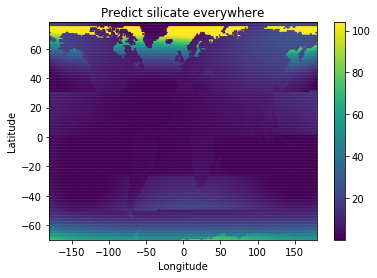

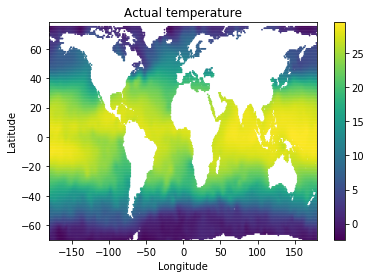

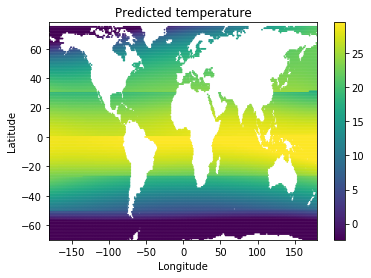

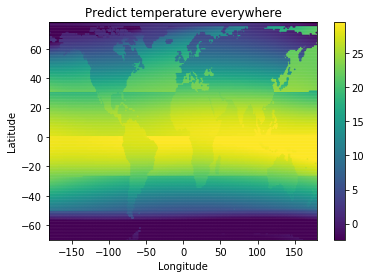

In [51]:
from dretch.spec import Ordinal, Spec
from dretch import ingest
import glabrezu as gl
from sklearn.model_selection import train_test_split, KFold

def crossval(train, folds=5, shuffle=True, random_state=0):
    """Obtain unbaised prediction using cross valiadtion."""
    n = len(train)
    if shuffle:
        rnd = np.random.RandomState(random_state)
        shuffle_ind = rnd.choice(range(n), n, replace=False)
        train = train[shuffle_ind]
    prediction = np.zeros(n)
    kfold = KFold(folds)
    for tr, ts in kfold.split(range(n)):
        instance = gl.train(m, train[tr])
        prediction[ts] = gl.predict(instance, train[ts]).prediction.flatten()
    return prediction


models = {
    "GPflow": gl.regressors.GPR(kernel=gl.gpflow.kernels.RBF),
    "BayesRidge": gl.regressors.BayesRidge(),
    "Linear": gl.regressors.LinearRegression(),
    "Lasso": gl.regressors.Lasso()
}


# loop through features
for i in range(len(features)):
    # mean impute chemical first
    mn = np.mean(chem_train[features[i]])
    isnan = pd.isnull(chem_train[features[i]])
    chem_train[features[i]][isnan] = mn
    c = chem_train[features[i]].values
    vmin, vmax = c.min(), c.max()
    
    # parse csv to modron object
    specX = Spec("longitude", Ordinal(), "latitude", Ordinal())
    specY = Spec(features[i], Ordinal())
    train = ingest.parse(chem_train, specX, specY, "Numpy").values()
    query = ingest.parse(chem_query, specX, None, "Numpy").values()


    # choose transformation and model
    transformation = [gl.transforms.PolynomialBasis(degree=5)]
    m = gl.Pipeline(transformation, models["Lasso"])

    # crossval and get prediction for whole train set   
    ptrain = crossval(train, shuffle=False)
    draw_global(lon, lat, train.Y.ordinal.flatten(), "Actual " + features[i],
                vmin=vmin, vmax=vmax)
    draw_global(lon, lat, ptrain, "Predicted " + features[i],
                vmin=vmin, vmax=vmax)

    # now predict for whole world
    instance = gl.train(m, train)
    pquery = gl.predict(instance, query).prediction.flatten()
    wlon = np.append(lon, chem_query["longitude"].values)
    wlat = np.append(lat, chem_query["latitude"].values)
    wp = np.append(ptrain, pquery)
    draw_global(wlon, wlat, wp, "Predict {} everywhere".format(features[i]),
                vmin=vmin, vmax=vmax)